<a href="https://colab.research.google.com/github/tonchan1216/bitbot/blob/master/notebook/predict_trend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.lite as tflite

from IPython.display import Image
from sklearn.model_selection import train_test_split

## データの読み込み

対象データ: BTC/JPYのレートにおける各日の終値

対象期間：20215 1/1 - 2020 12/30

データソース：Cryptowatch

In [2]:
drive.mount('/content/drive/')

base_path = '/content/drive/My Drive/Colab Notebooks/bitbot/training_data/'
train_data = pd.read_csv(base_path + 'btc_all.csv')

Mounted at /content/drive/


## 前処理

### INPUT

BTCのレートが格納されたDataframe

### Parameter

shift: (入力となる日数: 7) + (トレンドを予測する日数: 1)

threashold: OUTPUTを判定する閾値

### OUTPUT

- 上昇率N％以上で、上昇
- 下降率N％以下で、下降
- それ以外は停滞

In [3]:
def process(input_df, shift = 8, threshold = 0.02):
  ## データを一週間分シフト
  x = pd.concat([input_df.shift(-1*i) for i in range(shift)], axis=1)
  x = x.dropna()
  x = x.set_axis([str(i-6) for i in range(shift)], axis=1)

  ## 変動率の算出
  change_rate = (x['1'] - x['0']) / x['0']

  ## データの標準化
  m = np.array(x.mean(axis='columns'))
  s = np.array(x.std(axis='columns'))
  x = x.sub(m, axis=0).div(s, axis=0)

  ## 正解データの作成
  y = pd.DataFrame({'up': np.zeros(len(x)), 'down': np.zeros(len(x)), 'even': np.zeros(len(x))})
  y.loc[change_rate > threshold, 'up'] = 1 # 上昇トレンド
  y.loc[change_rate < -threshold, 'down'] = 1 # 下降トレンド
  y.loc[(change_rate <= threshold) & (change_rate >= -threshold), 'even'] = 1 # 停滞トレンド

  x = x.drop('1',axis=1)
  return np.array(x), np.array(y)

reference_day = 7
input_tensor, label_tensor = process(train_data['BTC'], shift = reference_day + 1, threshold = 0.01)
train_x, test_x, train_y, test_y = train_test_split(input_tensor, label_tensor, test_size=0.2, random_state=100, shuffle = True)

print('train data num: ', train_x.shape[0])
print(np.count_nonzero(train_y == 1, axis=0))

print('test data num: ', test_x.shape[0])
print(np.count_nonzero(test_y == 1, axis=0))

train data num:  1897
[665 533 699]
test data num:  475
[173 132 170]


## Model構築

LSTMを使ったニューラルネットワーク

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7)                 252       
                                                                 
 dense (Dense)               (None, 3)                 24        
                                                                 
Total params: 276
Trainable params: 276
Non-trainable params: 0
_________________________________________________________________
None


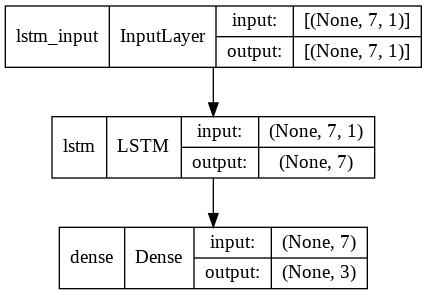

In [4]:
optimizer = Nadam()

model = Sequential()
## 入力層
model.add(LSTM(reference_day,
             dropout=0.2,
             recurrent_dropout=0,
             input_shape=(reference_day,1)))
## 中間層(なし)
# model.add(Dropout(0.2))
# model.add(Dense(5, activation='relu'))
## 出力層
model.add(Dense(3, activation='softmax'))
model.compile(optimizer=optimizer,
           loss='categorical_crossentropy',
           metrics=['acc'])

print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)
Image('model.png')

## 学習

過学習を防ぐために、EarlyStoppingを定義

学習中の検証結果を出力

In [5]:
earlystopping = EarlyStopping(monitor='loss', patience=5)

history = model.fit(train_x, train_y,
 batch_size=10,
 epochs=100,
 callbacks=[earlystopping],
 verbose=1,
 validation_data=(test_x, test_y))

Epoch 1/100
190/190 [==============================] - 7s 11ms/step - loss: 1.0840 - acc: 0.3917 - val_loss: 1.0594 - val_acc: 0.4463
Epoch 2/100
190/190 [==============================] - 1s 8ms/step - loss: 1.0455 - acc: 0.4602 - val_loss: 1.0004 - val_acc: 0.4989
Epoch 3/100
190/190 [==============================] - 1s 8ms/step - loss: 1.0157 - acc: 0.4860 - val_loss: 0.9608 - val_acc: 0.6253
Epoch 4/100
190/190 [==============================] - 1s 8ms/step - loss: 0.9997 - acc: 0.5029 - val_loss: 0.9289 - val_acc: 0.6126
Epoch 5/100
190/190 [==============================] - 1s 7ms/step - loss: 0.9839 - acc: 0.5008 - val_loss: 0.9063 - val_acc: 0.6000
Epoch 6/100
190/190 [==============================] - 1s 8ms/step - loss: 0.9857 - acc: 0.5076 - val_loss: 0.8978 - val_acc: 0.6295
Epoch 7/100
190/190 [==============================] - 2s 8ms/step - loss: 0.9911 - acc: 0.4955 - val_loss: 0.8946 - val_acc: 0.6400
Epoch 8/100
190/190 [==============================] - 1s 8ms/step -

## 可視化

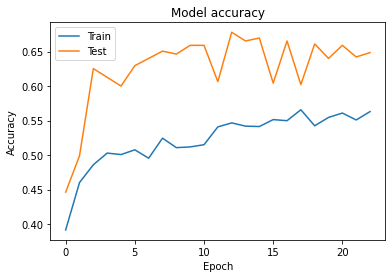

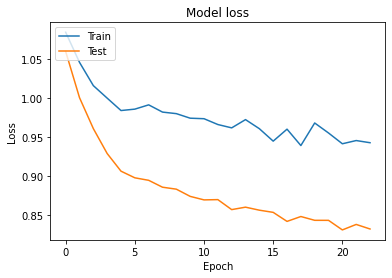

In [6]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 評価

モデルの最終評価をevaluateで行う

In [7]:
test_loss, test_acc = model.evaluate(test_x[:,:,np.newaxis], test_y)

15/15 [==============================] - 1s 5ms/step - loss: 0.8323 - acc: 0.6484


## 保存

TensorFlow2 からTensorFlow Liteへのモデル変換

https://qiita.com/sn6/items/252b0e201a72d73124a3

In [12]:
mdl_dir = '/content/drive/My Drive/Colab Notebooks/bitbot/models/prediction'
converter = tflite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tflite.OpsSet.TFLITE_BUILTINS, tflite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflmodel = converter.convert()

open(mdl_dir + '.tflite', 'wb').write(tflmodel)

INFO:tensorflow:Assets written to: /tmp/tmplwje3xsh/assets


INFO:tensorflow:Assets written to: /tmp/tmplwje3xsh/assets


10556